In [460]:
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.special import loggamma
from jax import vmap
from jax.scipy.special import j1

In [461]:
# Defining the relevant functions:

def mellin_wavelengths(wavelengths, weights, freqs):
    
    d_wl = (wavelengths[1]-wavelengths[0])

    prefac = 1/np.sqrt(2*np.pi)

    mellin = np.zeros_like(freqs, dtype=np.complex64)
    for idx, freq in enumerate(freqs):
        mel = np.sum(weights * wavelengths**(1j * freq - 1) * d_wl)
        mellin = mellin.at[idx].set(mel)

    mellin *= prefac
    return mellin

def h_kernel(freqs, diameter):
    logfisher = loggamma(1-1j*freqs/2) + loggamma(1/2 + 1j*freqs/2) - loggamma(1/2) - loggamma(3/2 - 1j*freqs/2) - loggamma(5/2 - 1j*freqs/2)

    prefac = (np.pi**(-1j*freqs) * diameter**(1-1j*freqs))/(2*np.sqrt(2*np.pi))

    fisher = np.exp(logfisher)

    fisher *= prefac
    return fisher

def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs):

    prefac = 1/(r_coords)# NO FACTOR OF sqrt2pi,,, cancels because unitary fourier transform convolution theorem * np.sqrt(2*np.pi))
    d_freq = freqs[1] - freqs[0]

    def single_poly(r):
        return np.sum(mellin_spec * h_hat * np.exp(-1.0j * freqs * np.log(r)) * d_freq)

    flat = vmap(single_poly)(r_coords.ravel())
    polychrome = flat.reshape(r_coords.shape) * prefac
    return polychrome

# this ben popes implimentation of the bessel func of first kind
def polyairydisk(r_coords, wavelengths, norm_weights, diameter):
    d_wl = wavelengths[1] - wavelengths[0]
    def single_wavelength(r):
        return np.sum(norm_weights * (1/wavelengths**2) * np.pi * diameter**2 * (j1(np.pi*diameter*r/wavelengths))**2/(np.pi*diameter*r/wavelengths)**2 * d_wl)
    
    flat = vmap(single_wavelength)(r_coords.ravel())
    polyairy = flat.reshape(r_coords.shape)

    return polyairy

# requires linearly spaced
def normalise_weights(wavelengths, weights):
    d_wl = wavelengths[1]- wavelengths[0]
    weights_norm = weights/(np.sum(weights)*d_wl)
    return weights_norm

# Defining inverse mellin
def inverse_mellin(freqs, melweights, wavelengths):
    prefac = 1/np.sqrt(2*np.pi)

    d_freq = freqs[1] - freqs[0]

    inv_mellin = np.zeros_like(wavelengths, dtype=np.complex64)
    for idx, wl in enumerate(wavelengths):
        inv_mel = np.sum(melweights * wl **(-1j*freqs) * d_freq)
        inv_mellin = inv_mellin.at[idx].set(inv_mel)

    inv_mellin *= prefac
    return inv_mellin

# defining single wavelength airy disk:
def singleairydisk(r_coords, wavelength0, diameter):
    prefac = 1/wavelength0**2 * np.pi * diameter**2
    arg = np.pi * diameter* r_coords/wavelength0
    airy = j1(arg)**2/arg**2
    airy *= prefac
    return airy

# defining the melin of a single wavelength (delta function)
def mellin_delta(freqs, wavelength0):
    prefac = 1/np.sqrt(2*np.pi)
    arg = wavelength0**(1j*freqs - 1)
    return prefac*arg

In [462]:
key = jr.PRNGKey(0)

psf_npixels = 16
oversample = 4
psf_pixel_scale = 0.375
diameter = 0.125

r_coords = dlu.pixel_coords(psf_npixels*oversample, dlu.arcsec2rad(psf_pixel_scale*psf_npixels),True)[0]

wavelength = 585e-9

# compare to mellin version
# define a maximum frequency
max_freq = 500
n_freqs = 10000
freqs = np.linspace(-max_freq, max_freq, n_freqs)

melspec = 1*mellin_delta(freqs, wavelength) #+0.5* mellin_delta(freqs, 600e-9)

# getting inverse mellin weights (for plotting)
# just gonna get some extra wavelengths dont mind me

h_kern = h_kernel(freqs, diameter)

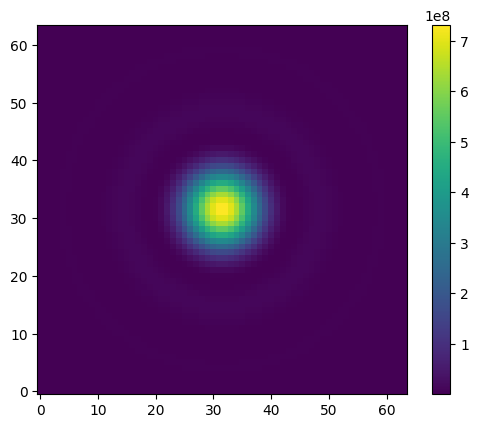

In [463]:
import optax
from jax import jit, value_and_grad
# radians to pixels
rad_to_pix = dlu.arcsec2rad(psf_pixel_scale/oversample)
# flux
# e12 is too high.. poisson breaks
# e5 has noticable zeros at this resolution

flux = 1e11

# --- model / forward -------------------------------------------------------
@jit
def polychrome_image_jax(r_coords, mellin_spec, h_hat, freqs):
    # r_coords: (H,W) or (N,)
    d_freq = freqs[1] - freqs[0]
    flat_r = r_coords.ravel()
    log_r = np.log(flat_r)               # ensure r>0 (avoid r=0)
    phasors = np.exp(-1.0j * np.outer(log_r, freqs))   # (N, F)
    contrib = (mellin_spec * h_hat * d_freq)             # (F,)
    flat = phasors @ contrib                             # (N,) complex
    polychrome = flat.reshape(r_coords.shape) / r_coords
    # convert to pixels
    polychrome *= rad_to_pix**2
    # add flux
    polychrome *= flux
    return np.maximum(np.real(polychrome),1e-12)

model_psf = polychrome_image_jax(r_coords, melspec, h_kern, freqs)

plt.imshow(model_psf, origin='lower')
plt.colorbar()
plt.show()

In [471]:
import jax
from jax import jit
from jax.flatten_util import ravel_pytree
import jax.scipy as jsp

# --- user-provided pieces (adapted) ---------------------------------------
# your polychrome_image_jax -> returns predicted mean counts per pixel (mu)
# assume it takes `params` as one of the inputs (here I show a wrapper below)
# ---------------------------------------------------------------------------

# Example wrapper: adapt your polychrome_image_jax to accept a params pytree.
# Here `params` could contain arrays like 'mellin_spec_real', 'mellin_spec_imag', 'h_hat', etc.
def model_from_params(params, r_coords, freqs):
    # Example: rebuild mellin_spec from params if you store it split into real+imag
    # Replace with your actual mapping from params -> mellin_spec, h_hat
    mellin_spec = params['mag'] * np.exp(1j*np.angle(melspec))
    # call your existing forward function (which returns real-valued mu)
    mu = polychrome_image_jax(r_coords, mellin_spec, h_kern, freqs)
    # enforce positivity and minimum floor to avoid log(0)
    mu = np.maximum(mu, 1e-12)
    return mu  # shape (N,) or (H,W)

# --- Poisson log-likelihood (sum over pixels) -------------------------------
# y: observed integer counts, same shape as mu
def poisson_loglik(params, r_coords, freqs, y):
    mu = model_from_params(params, r_coords, freqs)      # predicted means
    # If you want the full loglik including factorial term:
    # term = y * jnp.log(mu) - mu - jsp.special.gammaln(y + 1.0)
    # but gammaln(y+1) is independent of params so it's safe to drop when differentiating.
    ll = np.sum(y * np.log(mu) - mu)
    return ll

# Gaussian loglikelihood. Just minimise the squares
def gauss_loglik(params, r_coords, freqs, y):
    mu = model_from_params(params, r_coords, freqs)

    ll = np.sum(-(mu-y)**2)
    return ll

# --- Flatten params to a vector so Hessian is a (P,P) array -----------------
# given an example initial params pytree `params0`
# how do I do this part?
params0 = {
    'mag': np.asarray(np.abs(np.asarray(melspec))),   # use your initial melspec
}

flat_params0, unravel_fn = ravel_pytree(params0)   # flat_params0 is a jnp vector

# scalar function taking flat vector -> scalar loglik
def scalar_loglik_flat(flat_x, y):
    params = unravel_fn(flat_x)
    return poisson_loglik(params, r_coords, freqs, y)
    #return gauss_loglik(params, r_coords, freqs, y)

# negative log-likelihood (useful for e.g. optimization; Hessian of -loglik is often used)
neg_scalar = lambda v: - scalar_loglik_flat(v)

observed_fisher = - jax.jit(jax.hessian(scalar_loglik_flat))(flat_params0, model_psf)

In [497]:
# fisher info
max_r = np.max(r_coords)

n_rs = 1024
# right so with small enough r this totally doesnt converge
# we will do from smallest radius to central pixel coordinate
min_r = np.min(r_coords)

rs_int = np.linspace(min_r,max_r,n_rs)

def inverse_nu_integral(rs_int, wavelength, diameter):
    d_r = rs_int[1] - rs_int[0]

    inuint = np.sum(1/(rs_int*singleairydisk(rs_int, wavelength, diameter)) * d_r)

    return inuint

def inverse_mu_integral(r_coords, mu):
    imuint = np.sum(1/(r_coords**2 * mu))
    # no need for a dxdy factor because mu is in photons per pixel
    return imuint

inv_nu_int = inverse_nu_integral(rs_int, wavelength, diameter)
inv_mu_int = inverse_mu_integral(r_coords, model_psf)

fisher_info = (2 * np.pi) * np.abs(h_kern)**2 * inv_nu_int * flux

fisher_info_2 = np.abs(h_kern)**2 * inv_mu_int

In [498]:
# cov_matrix = np.linalg.inv(observed_fisher)

# cov_diag = np.diag(cov_matrix)

d_freq = freqs[1]-freqs[0]
avg = int(10*np.ceil(1/d_freq)+1)

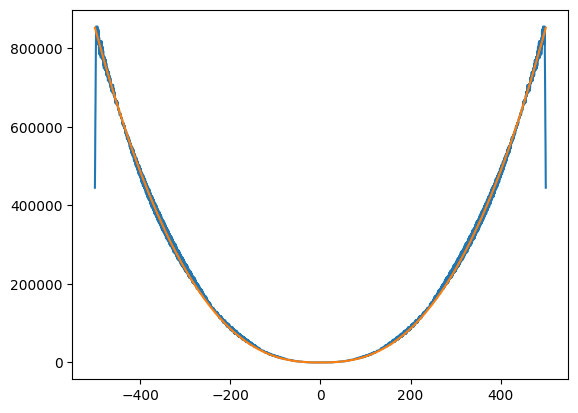

In [504]:
#plt.plot(freqs, 1/np.sqrt(np.diag(observed_fisher)))
plt.plot(freqs, np.convolve(1/np.sqrt(np.diag(observed_fisher)), np.ones(51)/(51), mode='same'))

#plt.plot(freqs, cov_diag)
plt.plot(freqs, 4/np.sqrt(d_freq**2*fisher_info))
# inverse nu int works best.
#plt.plot(freqs, 64/np.sqrt(d_freq**2 * fisher_info_2))
#plt.ylim(0,1.5*enp.median(1/np.sqrt(np.diag(observed_fisher))))
plt.show()

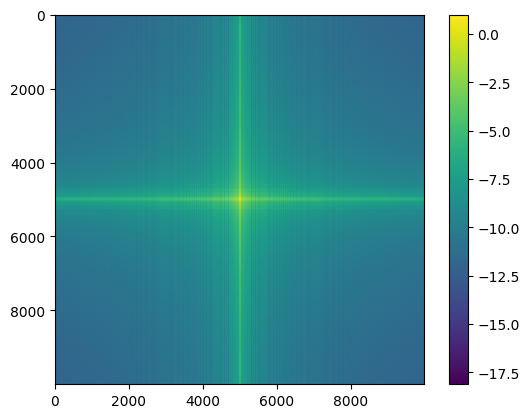

In [501]:
plt.imshow(np.log10(np.abs(observed_fisher)))
plt.colorbar()
plt.show()